In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import viridis, Set2 as NodeColors
import math

B-spline as a recursive convolution of the box function:
  https://reproducibility.org/RSF/book/sep/forwd/paper_html/node10.html

B-splines converge to a Gaussian (footnote 8)
    https://bayesiancomputationbook.com/markdown/chp_05.html

Maximum value of a b-spline
    https://mathoverflow.net/questions/254361/maximum-of-a-b-spline


In [2]:
def b0(x):
    """Zero-th order B-spline (box)"""
    x = torch.as_tensor(x)
    return ((-0.5 <= x) & (x < 0.5)).to(x)

def zero(x):
    """Gradient of zero-th order B-spline (zeros)"""
    x = torch.as_tensor(x)
    return torch.zeros_like(x)

def scale_fn(b):
    """Scale a b-spline such that its peak is 1"""
    def newb(x):
        b0 =  b(0)
        y = b(x / b0)
        y /= b0
        return y
    return newb

def make_b(n, scale=False):
    """B-spline function of any order"""
    if n == 0:
        return b0

    bprev = make_b(n-1)

    def bn(x):
        return (bprev(x + 0.5) * (x + (n+1)/2) + bprev(x-0.5) * ((n+1)/2 - x)) / n

    return scale_fn(bn) if scale else bn


def make_g(n, scale=False):
    """Gradient of the B-spline function of any order"""
    if n == 0:
        return zero

    bprev = make_b(n-1)
    gprev = make_g(n-1)

    def gn(x):
        if scale:
            bn0 = make_b(n)(0)
            x = x / bn0
        g = gprev(x + 0.5) * (x + (n+1)/2) + gprev(x-0.5) * ((n+1)/2 - x)
        g += bprev(x + 0.5) - bprev(x-0.5)
        g /= n
        if scale:
            g /= bn0**2
        return g

    return gn


def make_h(n, scale=False):
    """Hessian of the B-spline function of any order"""
    if n == 0:
        return zero

    gprev = make_g(n-1)
    hprev = make_h(n-1)

    def hn(x):
        if scale:
            bn0 = make_b(n)(0)
            x = x / bn0
        h = hprev(x + 0.5) * (x + (n+1)/2) + hprev(x-0.5) * ((n+1)/2 - x)
        h += (gprev(x + 0.5) - gprev(x-0.5)) * 2
        h /= n
        if scale:
            h /= bn0**3
        return h

    return hn

def binf(x):
    """Infinite-order unit-height spline == gaussian"""
    x = torch.as_tensor(x)
    return (- math.pi * x.square()).exp()

def ginf(x):
    """Gradient of the Gaussian"""
    x = torch.as_tensor(x)
    return - 2 * math.pi * x * binf(x)

def hinf(x):
    """Hessian of the Gaussian"""
    x = torch.as_tensor(x)
    return ((2 * math.pi * x).square() - 2 * math.pi) * binf(x)

In [3]:
def b3(x):
    """Non-recursive implementation of cubic spline (for testing)"""
    x = x.abs()
    x_low = (x * x * (x - 2.) * 3. + 4.) / 6.
    x_up = (2. - x) ** 3 / 6.
    return torch.where(x < 1., x_low, x_up).masked_fill_(x > 2, 0)

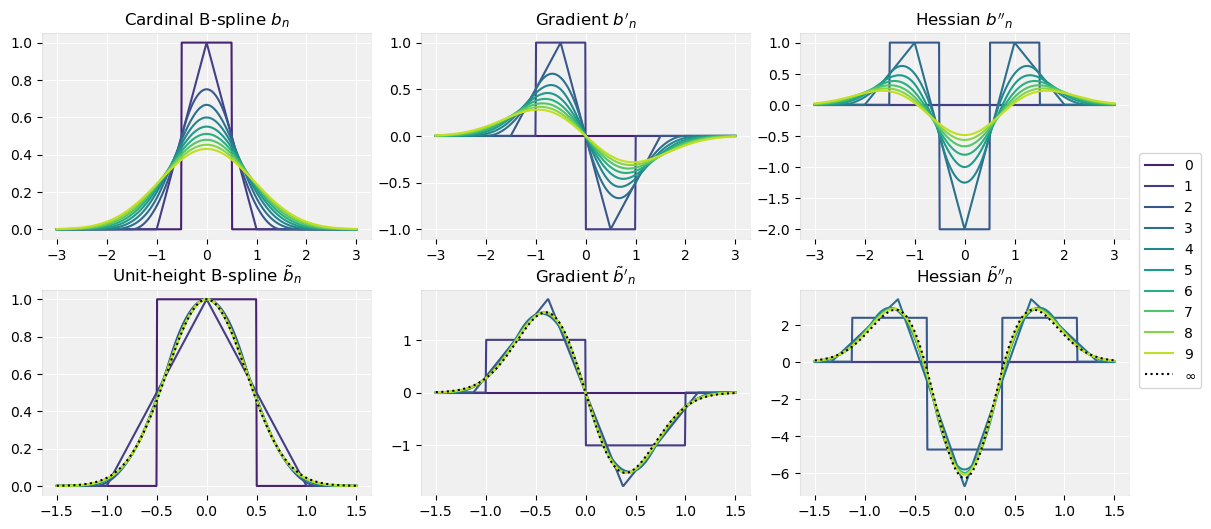

In [4]:
plt.figure(figsize=(15, 6))

nb_order = 10
colors = viridis(torch.linspace(0, 1, nb_order+2))[1:]

x = torch.linspace(-3, 3, 512)

plt.subplot(2, 3, 1)
plt.gca().set_facecolor('#0F0F0F0F')
plt.gca().spines['top'].set_color('#0F0F0F0F')
plt.gca().spines['bottom'].set_color('#0F0F0F0F')
plt.gca().spines['left'].set_color('#0F0F0F0F')
plt.gca().spines['right'].set_color('#0F0F0F0F')
# plt.gca().tick_params(axis='x', color='w')
plt.grid(color='white')
for n in range(nb_order):
    plt.plot(x, make_b(n)(x), color=colors[n])
# plt.legend(range(nb_order))
plt.gca().set_facecolor('#0F0F0F0F')
plt.title(r"Cardinal B-spline $b_n$")
# plt.plot(x, binf(x), color=colors[-1])

plt.subplot(2, 3, 2)
plt.gca().set_facecolor('#0F0F0F0F')
plt.gca().spines['top'].set_color('#0F0F0F0F')
plt.gca().spines['bottom'].set_color('#0F0F0F0F')
plt.gca().spines['left'].set_color('#0F0F0F0F')
plt.gca().spines['right'].set_color('#0F0F0F0F')
# plt.gca().tick_params(axis='x', color='w')
plt.grid(color='white')
for n in range(nb_order):
    plt.plot(x, make_g(n)(x), color=colors[n])
plt.gca().set_facecolor('#0F0F0F0F')
plt.title(r"Gradient $b'_n$")
# plt.plot(x, binf(x), color=colors[-1])

plt.subplot(2, 3, 3)
plt.gca().set_facecolor('#0F0F0F0F')
plt.gca().spines['top'].set_color('#0F0F0F0F')
plt.gca().spines['bottom'].set_color('#0F0F0F0F')
plt.gca().spines['left'].set_color('#0F0F0F0F')
plt.gca().spines['right'].set_color('#0F0F0F0F')
# plt.gca().tick_params(axis='x', color='w')
plt.grid(color='white')
for n in range(nb_order):
    plt.plot(x, make_h(n)(x), color=colors[n])
plt.gca().set_facecolor('#0F0F0F0F')
plt.title(r"Hessian $b''_n$")

x = torch.linspace(-1.5, 1.5, 512)

plt.subplot(2, 3, 4)
plt.gca().set_facecolor('#0F0F0F0F')
plt.gca().spines['top'].set_color('#0F0F0F0F')
plt.gca().spines['bottom'].set_color('#0F0F0F0F')
plt.gca().spines['left'].set_color('#0F0F0F0F')
plt.gca().spines['right'].set_color('#0F0F0F0F')
# plt.gca().tick_params(axis='x', color='w')
plt.grid(color='white')
for n in range(nb_order):
    plt.plot(x, make_b(n, True)(x), color=colors[n])
plt.plot(x, binf(x), ':k')
plt.gca().set_facecolor('#0F0F0F0F')
plt.legend(list(range(nb_order)) + [r'$\infty$'],
           bbox_to_anchor=(3.54, 1.7))
plt.title(r"Unit-height B-spline $\tilde{b}_n$")

plt.subplot(2, 3, 5)
plt.gca().set_facecolor('#0F0F0F0F')
plt.gca().spines['top'].set_color('#0F0F0F0F')
plt.gca().spines['bottom'].set_color('#0F0F0F0F')
plt.gca().spines['left'].set_color('#0F0F0F0F')
plt.gca().spines['right'].set_color('#0F0F0F0F')
# plt.gca().tick_params(axis='x', color='w')
plt.grid(color='white')
for n in range(nb_order):
    plt.plot(x, make_g(n, True)(x), color=colors[n])
plt.plot(x, ginf(x), ':k')
plt.gca().set_facecolor('#0F0F0F0F')
plt.title(r"Gradient $\tilde{b}'_n$")

plt.subplot(2, 3, 6)
plt.gca().set_facecolor('#0F0F0F0F')
plt.gca().spines['top'].set_color('#0F0F0F0F')
plt.gca().spines['bottom'].set_color('#0F0F0F0F')
plt.gca().spines['left'].set_color('#0F0F0F0F')
plt.gca().spines['right'].set_color('#0F0F0F0F')
# plt.gca().tick_params(axis='x', color='w')
plt.grid(color='white')
for n in range(nb_order):
    plt.plot(x, make_h(n, True)(x), color=colors[n])
plt.plot(x, hinf(x), ':k')
plt.gca().set_facecolor('#0F0F0F0F')
plt.title(r"Hessian $\tilde{b}''_n$")

plt.subplots_adjust(right=0.85, wspace=0.15, hspace=0.25)
# plt.tight_layout()
plt.savefig('/Users/yb947/Dropbox/papers/YB24_splinereg/bspline.pdf')
plt.show()


In [5]:
# FWHM of unit-height Gaussian
2 * math.sqrt(math.log(2) / math.pi)

0.9394372786996513

In [6]:
def index_dct2(i, n):
    # also: dst2
    i = torch.as_tensor(i)
    n2 = n * 2
    i = torch.where(i < 0, (-i-1).remainder(n2).neg().add(n2 - 1),
                    i.remainder(n2))
    i = torch.where(i >= n, -i + (n2 - 1), i)
    return i

def index_dct1(i, n):
    i = torch.as_tensor(i)
    if n == 1:
        return torch.zeros(i.shape, dtype=i.dtype, device=i.device)
    else:
        n2 = (n - 1) * 2
        i = i.abs().remainder(n2)
        i = torch.where(i >= n, -i + n2, i)


def index_dst1(i, n):
    i = torch.as_tensor(i)
    n2 = 2 * (n + 1)
    first = torch.zeros([1], dtype=i.dtype, device=i.device)
    last = torch.full([1], n - 1, dtype=i.dtype, device=i.device)
    i = torch.where(i < 0, -i - 2, i)
    i = i.remainder(n2)
    i = torch.where(i > n, -i + (n2 - 2), i)
    i = torch.where(i == -1, first, i)
    i = torch.where(i == n, last, i)
    return i

def index_dft(i, n):
    i = torch.as_tensor(i)
    return i.remainder(n)


def sign_dst1(i, n):
    i = torch.as_tensor(i)
    if n == 1:
        return torch.ones_like(i, dtype=torch.int8)
    one = torch.ones([1], dtype=torch.int8, device=i.device)
    zero = torch.zeros([1], dtype=torch.int8, device=i.device)
    n2 = 2 * (n + 1)
    i = torch.where(i < 0, -i + (n-1), i)
    i = i.remainder(n2)
    x = torch.where(i == 0, zero, one)
    x = torch.where(i.remainder(n + 1) == n, zero, x)
    i = torch.floor_divide(i, n+1)
    x = torch.where(torch.remainder(i, 2) > 0, -x, x)
    return x

def sign_dst2(i, n):
    i = torch.as_tensor(i)
    i = torch.where(i < 0, n - 1 - i, i)
    x = torch.ones([1], dtype=torch.int8, device=i.device)
    i = torch.floor_divide(i, n)
    x = torch.where(torch.remainder(i, 2) > 0, -x, x)
    return x

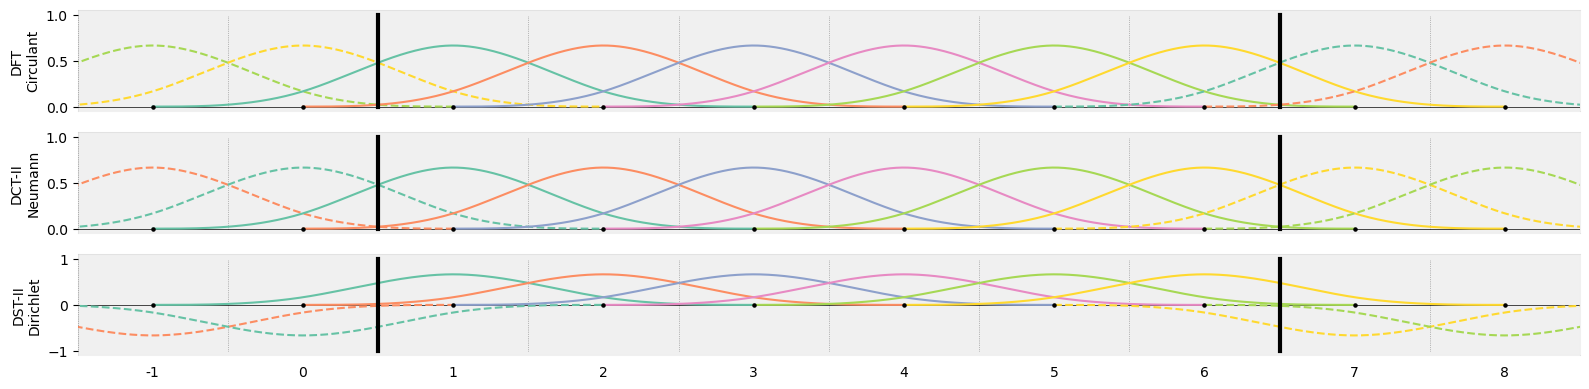

In [7]:
colors = NodeColors(range(6))

plt.figure(figsize=(16, 4))

plt.subplot(3, 1, 1)
plt.gca().set_facecolor('#0F0F0F0F')
plt.gca().spines['top'].set_color('#0F0F0F0F')
plt.gca().spines['bottom'].set_color('#0F0F0F0F')
plt.gca().spines['left'].set_color('#0F0F0F0F')
plt.gca().spines['right'].set_color('#0F0F0F0F')
plt.gca().tick_params(axis='x', color='w')
plt.plot([-4, 9], [0, 0], 'k', linewidth=0.5)
for i in range(-4, 9):
    i += 0.5
    is_border = i in (-0.5, 5.5)
    plt.plot([i, i], [0, 1],
             '-' if is_border else ':',
             color='black' if is_border else 'gray',
             linewidth=3 if is_border else 0.5,
             zorder=100 if is_border else -1)
for i in range(-2, 8):
    symbol = '-' if i in range(6) else '--'
    x = torch.linspace(i-2, i+2, 512)
    plt.plot(x, b3(x - i), symbol, color=colors[index_dft(i, 6).item()])
for i in range(-2, 8):
    plt.scatter([i], [0], 5, color='black', zorder=100)
plt.xticks(ticks=range(-3, 9), labels=[])
plt.ylabel('DFT\nCirculant')
plt.xlim([-2.5, 7.5])

plt.subplot(3, 1, 2)
plt.gca().set_facecolor('#0F0F0F0F')
plt.gca().spines['top'].set_color('#0F0F0F0F')
plt.gca().spines['bottom'].set_color('#0F0F0F0F')
plt.gca().spines['left'].set_color('#0F0F0F0F')
plt.gca().spines['right'].set_color('#0F0F0F0F')
plt.gca().tick_params(axis='x', color='w')
plt.plot([-4, 9], [0, 0], 'k', linewidth=0.5)
for i in range(-4, 9):
    i += 0.5
    is_border = i in (-0.5, 5.5)
    plt.plot([i, i], [0, 1],
             '-' if is_border else ':',
             color='black' if is_border else 'gray',
             linewidth=3 if is_border else 0.5,
             zorder=100 if is_border else -1)
for i in range(-2, 8):
    symbol = '-' if i in range(6) else '--'
    x = torch.linspace(i-2, i+2, 512)
    plt.plot(x, b3(x - i), symbol, color=colors[index_dct2(i, 6).item()])
for i in range(-2, 8):
    plt.scatter([i], [0], 5, color='black', zorder=100)
plt.xticks(ticks=range(-3, 9), labels=[])
plt.ylabel('DCT-II\nNeumann')
plt.xlim([-2.5, 7.5])

plt.subplot(3, 1, 3)
plt.gca().set_facecolor('#0F0F0F0F')
plt.gca().spines['top'].set_color('#0F0F0F0F')
plt.gca().spines['bottom'].set_color('#0F0F0F0F')
plt.gca().spines['left'].set_color('#0F0F0F0F')
plt.gca().spines['right'].set_color('#0F0F0F0F')
plt.gca().tick_params(axis='x', color='w')
plt.plot([-4, 9], [0, 0], 'k', linewidth=0.5)
for i in range(-4, 9):
    i += 0.5
    is_border = i in (-0.5, 5.5)
    plt.plot([i, i], [-1, 1],
             '-' if is_border else ':',
             color='black' if is_border else 'gray',
             linewidth=3 if is_border else 0.5,
             zorder=100 if is_border else -1)
for i in range(-2, 8):
    flip = sign_dst2(i, 6).item()
    symbol = '-' if i in range(6) else '--'
    x = torch.linspace(i-2, i+2, 512)
    plt.plot(x, b3(x - i) * flip, symbol, color=colors[index_dct2(i, 6).item()])
for i in range(-2, 8):
    plt.scatter([i], [0], 5, color='black', zorder=100)
plt.xticks(ticks=range(-3, 9), labels=[''] + list(range(-1, 9)) + [''])
plt.ylabel('DST-II\nDirichlet')
plt.xlim([-2.5, 7.5])

plt.tight_layout()
plt.savefig('/Users/yb947/Dropbox/papers/YB24_splinereg/bounds.pdf')
plt.show()